### 4. Drug-by-drug training of best models with tuned hyperparameters for Coefficient 4+RFE

  1. perform new drug-by-drug-training and testing for the best model and calculated:
        - mae +/- std mae
        - mre +/- std mre
  2. analysis of errors
  3. feature importance

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import time

import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import MinMaxScaler

np.random.seed(123)

_FOLDER = "results/"
_FOLDER_2 = "GridSearch_results/"
_FOLDER_3 = "figures/"
csfont = {'fontname':'Times New Roman'}

In [2]:
def TrainPredict_KR(train, test, target, drug_ids_list, X_columns, kernel, hyperparameters, 
                    degree = 3, print_drug_name = True):
    y_pred = []
    for drug_id in drug_ids_list:
        if print_drug_name:
            drug_name = train.loc[drug_id, "Drug_Name"].values[0]
            print(drug_id, drug_name)
        train_drug = train.loc[drug_id,:]
        test_drug = test.loc[drug_id,:]
        y_train_drug = train_drug[target].values
        y_test_drug =  test_drug[target].values
        scaler = MinMaxScaler().fit(train_drug[X_columns])
        Xtrain_drug = scaler.transform(train_drug[X_columns])
        
        model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"])
        model.fit(Xtrain_drug, y_train_drug)
        Xtest_drug = scaler.transform(test_drug[X_columns])
        
        y_pred.extend(model.predict(Xtest_drug))
    return y_pred

def TrainTest_KR(train, test, target, drug_ids_list, X_columns, kernel, hyperparameters, 
                    degree = 3, print_drug_name = True):
    
    y_pred = TrainPredict_KR(train_df_50, test_df_50, 
                                       target = target, drug_ids_list =drug_ids_50, 
                                       X_columns = X_columns, kernel = kernel, 
                                       hyperparameters= hyperparameters, print_drug_name = print_drug_name)

    abs_errors = abs(test_df_50[target] - y_pred)    
    rel_errors = abs(test_df_50[target] - y_pred)*100/test_df_50[target] 

    print("\nMAE:", round(abs_errors.mean(), 3), "+/-", round(abs_errors.std(), 3))
    print("MRE:", round(rel_errors.mean(), 1), "+/-", round(rel_errors.std(), 1))
    print("")
    print(train_df_50.shape, test_df_50.shape)
    return y_pred

### Coefficient 4 : RBF_KernelRidge

In [3]:
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_4.csv").drop(["Unnamed: 0"], axis=1)
hyperparameters.set_index("DRUG_ID", inplace = True)
hyperparameters

,best_alpha3,best_gamma3,best_coef03
DRUG_ID,,,
170,50.0,0.00001,0.01
173,0.1,1.00000,0.01
180,10.0,0.00010,0.01
200,0.1,0.00010,0.01
219,5.0,0.00001,0.01
272,10.0,0.00001,0.01
273,50.0,0.01000,0.01
274,100.0,0.00001,0.01
276,50.0,0.00001,0.01


### Reading default parameters

In [4]:
with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

X_feat_dict = {"Dataset_1": X_cancer_cell_lines ,
               "Dataset_2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset_3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset_4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

## Original training

In [5]:
with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

kernel = "rbf"
X_columns = X_feat_dict["Dataset_4"]

y_pred = TrainTest_KR(train_df_50, test_df_50, target = "param_4", 
                      drug_ids_list =drug_ids_50, X_columns = X_columns, 
                      kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)
test_df_50["y_pred"] = y_pred
test_df_50["abs_error"]= abs(test_df_50["param_4"] - y_pred)

170 Shikonin
173 FH535
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.069 +/- 0.087
MRE: -154.0 +/- 3177.3

(781, 1379) (202, 1379)


### Analysis of MAE on drug-by-drug basis

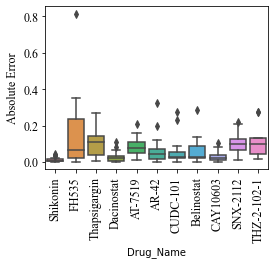

In [6]:
csfont = {'fontname':'Times New Roman'}
plt.figure(figsize=(4, 3))
sns.boxplot(x = "Drug_Name", y = "abs_error", data = test_df_50.reset_index())

plt.xticks(rotation = 90, fontsize=12, **csfont)
plt.yticks(fontsize=12, **csfont)
plt.ylabel("Absolute Error", fontsize=12, **csfont)
plt.savefig(_FOLDER_3+"coef_4.png", bbox_inches='tight');

In [7]:
test_df_50[test_df_50["param_4"]==-0.8150201075633312][["COSMIC_ID", "param_4", "y_pred"]]

,COSMIC_ID,param_4,y_pred
DRUG_ID,,,
173,687777,-0.81502,-8.772640e-15


In [8]:
test_df_50[test_df_50["COSMIC_ID"]==907064][["COSMIC_ID", "param_1", "y_pred"]]

,COSMIC_ID,param_1,y_pred
DRUG_ID,,,
180,907064,9.576391,0.168828


In [9]:
test_df_50[test_df_50["param_4"]<0]

,COSMIC_ID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,fd_num_5,fd_num_6,fd_num_7,...,Mitosis,Other,"Other, kinases",PI3K/MTOR signaling,Protein stability and degradation,RTK signaling,WNT signaling,p53 pathway,y_pred,abs_error
DRUG_ID,,,,,,,,,,,,,,,,,,,,,
170,906862,16.000,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,1,0,0,0,0,0,0,1.005730e-02,0.013806
170,1331039,16.000,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,1,0,0,0,0,0,0,1.005438e-02,0.036458
170,949170,16.000,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,1,0,0,0,0,0,0,1.005461e-02,0.022983
173,1240160,32.000,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,1,0,1.181049e-10,0.002206
173,687777,32.000,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,1,0,-8.772640e-15,0.815020
173,910947,32.000,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,1,0,3.118286e-10,0.081802
200,924240,1.024,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,0,0,1.218063e-02,0.037520
200,1331038,1.024,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,0,0,2.667127e-02,0.028944
219,908159,10.240,0,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,...,0,0,0,0,0,0,0,0,1.580122e-01,0.160624


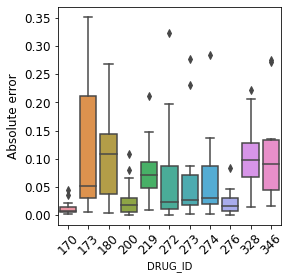

In [10]:
plt.figure(figsize=(4, 4))
sns.boxplot(x = "DRUG_ID", y = "abs_error", data = test_df_50[test_df_50["param_4"]>=0].reset_index())

plt.xticks(rotation = 45, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Absolute error", fontsize=12)
plt.savefig(_FOLDER_3+"coef_4_1.png", bbox_inches='tight');

### Retraining the model on the new data: Restriction for Coefficient

### Restriction in place for the ready data

In [11]:
del train_df_50
del test_df_50

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

train_df_50 = train_df_50[train_df_50["param_4"]>=0].copy()
test_df_50 = test_df_50[test_df_50["param_4"]>=0].copy()

y_pred = TrainTest_KR(train_df_50, test_df_50, target = "param_4", drug_ids_list =drug_ids_50, 
             X_columns = X_columns, kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

170 Shikonin
173 FH535
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.068 +/- 0.071
MRE: 316.0 +/- 1665.8

(648, 1379) (166, 1379)


### New data set with the restriction

In [12]:
del train_df_50
del test_df_50

with open(_FOLDER + "drug_ids_50_restr_coef.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_min10_restr_coef.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_min10_restr_coef.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

y_pred = TrainTest_KR(train_df_50, test_df_50, target = "param_4", drug_ids_list =drug_ids_50, 
             X_columns = X_columns, kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

test_df_50["y_pred"] = y_pred
test_df_50["abs_error"]=  abs(test_df_50["param_3"] - y_pred)

170 Shikonin
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.065 +/- 0.069
MRE: 389.2 +/- 1423.3

(588, 1380) (152, 1380)


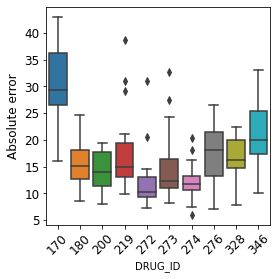

In [13]:
plt.figure(figsize=(4, 4))
sns.boxplot(x = "DRUG_ID", y = "abs_error", data = test_df_50[test_df_50["param_4"]>=0].reset_index())

plt.xticks(rotation = 45, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Absolute error", fontsize=12)
plt.savefig(_FOLDER_3+"coef_4_2.png", bbox_inches='tight');

In [14]:
train_df_50.shape, test_df_50.shape

(781-648)*100/781

17.02944942381562

### Retraining the model on the new data: Restriction for R2

In [15]:
del train_df_50
del test_df_50

with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    

train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

y_pred = TrainTest_KR(train_df_50, test_df_50, target = "param_4", 
                      drug_ids_list =drug_ids_50, X_columns = X_columns, 
                      kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

test_df_50["abs_error"]= abs(test_df_50["param_4"] - y_pred)

170 Shikonin
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.069 +/- 0.081
MRE: 99.1 +/- 984.1

(723, 1380) (185, 1380)


### Feature importance

In [16]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

df = pd.read_csv(_FOLDER_2 + "Linear_SVR_coef4.csv").rename(columns={"Unnamed: 0": "DRUG_ID"})

hyperparameters_rfe = df[['DRUG_ID', 'best_C3', 'best_epsilon3']].set_index("DRUG_ID")
# best.to_csv(_FOLDER+"best_model_coef_" +str(i)+ ".csv")
hyperparameters_rfe

,best_C3,best_epsilon3
DRUG_ID,,
170,0.01,0.001
173,0.01,0.010
180,0.01,0.010
200,0.01,0.010
219,0.01,1.000
272,0.01,0.001
273,0.01,0.001
274,0.01,0.010
276,0.01,1.000


## RFE on the original data

In [17]:
del train_df_50
del test_df_50

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]


all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

df_features = pd.DataFrame(index=drug_ids_50)
most_important = {}

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_4"].values
    y_test_drug =  test_drug["param_4"].values

    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    estimator = SVR(kernel = "linear", 
                    C = hyperparameters_rfe.loc[drug_id, 'best_C3'],
                    epsilon = hyperparameters_rfe.loc[drug_id,'best_epsilon3'])
    # feature selector
    selector = RFE(estimator, n_features_to_select=50, step=10)
    selector = selector.fit(Xtrain_drug, y_train_drug)
    most_important[drug_id] = np.array(X_columns)[selector.support_]
    
    #models parameters
    estimator.fit(Xtrain_drug, y_train_drug)
    df_features.loc[drug_id, "zero"] = len(estimator.coef_[estimator.coef_==0])
    df_features.loc[drug_id, "max"] = round(abs(estimator.coef_[0]).max(),3)
    df_features.loc[drug_id, "more_0_01"] =sum(abs(estimator.coef_[0])>0.01)
    
df_features["zero"] = df_features["zero"].astype('int32')
df_features["more_0_01"] = df_features["more_0_01"].astype('int32')
display(df_features)

display(pd.DataFrame(data= [int(df_features["zero"].mean()), df_features["max"].max(), int(df_features["more_0_01"].mean())]).T)

,zero,max,more_0_01
170,662,0.016,6
173,770,0.020,25
180,716,0.039,62
200,698,0.024,18
219,1352,0.000,0
272,508,0.029,57
273,604,0.019,52
274,625,0.021,38
276,1352,0.000,0
328,551,0.036,108


,0,1,2
0,794.0,0.039,33.0


In [18]:
all_features = []
for key in most_important.keys():
    all_features.extend(most_important[key])
most_important_features = set(all_features)
len(all_features), len(most_important_features)

df_features = pd.DataFrame(index = list(most_important_features), columns = drug_ids_50)
for drug_id in drug_ids_50:
    df_features[drug_id] = 0
    df_features.loc[most_important[drug_id], drug_id]=1

df_features["sum"]= df_features[drug_ids_50].sum(axis=1)
df_features.sort_values("sum", ascending = False)

from_CCLE = set(most_important_features)& set(X_cancer_cell_lines)
print("from CCL:", len(set(most_important_features)& set(X_cancer_cell_lines)))
print("from PubChem_properties",len( set(most_important_features)& set(X_PubChem_properties)))
print("from targets:", len(set(most_important_features)& set(X_targets)))
print("from target pathway:", len(set(most_important_features)& set(X_target_pathway)))

from CCL: 323
from PubChem_properties 0
from targets: 31
from target pathway: 0


## RFE on the reduced by R2 data

In [19]:
del train_df_50
del test_df_50

with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

# reduced by R2 filtration criteria    
train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

df_features_2 = pd.DataFrame(index=drug_ids_50)
most_important_2 = {}

for drug_id in drug_ids_50:
    drug_name = train_df_50.loc[drug_id, "Drug_Name"].values[0]
    
    train_drug = train_df_50.loc[drug_id,:]
    test_drug = test_df_50.loc[drug_id,:]
    y_train_drug = train_drug["param_4"].values
    y_test_drug =  test_drug["param_4"].values
    
    scaler = MinMaxScaler().fit(train_drug[X_columns])
    Xtrain_drug = scaler.transform(train_drug[X_columns])
        
    estimator = SVR(kernel = "linear", 
                    C = hyperparameters_rfe.loc[drug_id, 'best_C3'],
                    epsilon = hyperparameters_rfe.loc[drug_id,'best_epsilon3'])
    estimator.fit(Xtrain_drug, y_train_drug)
    df_features_2.loc[drug_id, "zero"] = len(estimator.coef_[estimator.coef_==0])
    df_features_2.loc[drug_id, "max"] = round(abs(estimator.coef_[0]).max(),3)
    df_features_2.loc[drug_id, "more_0_01"] =sum(abs(estimator.coef_[0])>0.01)

df_features_2["zero"] = df_features_2["zero"].astype('int32')
df_features_2["more_0_01"] = df_features_2["more_0_01"].astype('int32')
display(df_features_2)

display(pd.DataFrame(data= [int(df_features_2["zero"].mean()), df_features_2["max"].max(), int(df_features_2["more_0_01"].mean())]).T)

,zero,max,more_0_01
170,682,0.012,3
180,745,0.026,28
200,705,0.021,17
219,1352,0.000,0
272,506,0.021,51
273,629,0.023,41
274,557,0.026,31
276,1352,0.000,0
328,559,0.028,85
346,943,0.016,11


,0,1,2
0,803.0,0.028,26.0


## Training on the reduced data and subset of top50 features

In [20]:
def TrainPredict_KR_subset(train, test, target, drug_ids_list, subset_feat_dict, kernel, hyperparameters, 
                    degree = 3, print_drug_name = True):
    y_pred = []
    for drug_id in drug_ids_list:
        if print_drug_name:
            drug_name = train.loc[drug_id, "Drug_Name"].values[0]
            print(drug_id, drug_name)
        train_drug = train.loc[drug_id,:]
        test_drug = test.loc[drug_id,:]
        y_train_drug = train_drug[target].values
        y_test_drug =  test_drug[target].values
        X_columns = subset_feat_dict[drug_id]
        scaler = MinMaxScaler().fit(train_drug[X_columns])
        Xtrain_drug = scaler.transform(train_drug[X_columns])
        
        model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"])
        model.fit(Xtrain_drug, y_train_drug)
        Xtest_drug = scaler.transform(test_drug[X_columns])
        
        y_pred.extend(model.predict(Xtest_drug))
    return y_pred

def TrainTest_KR_subset(train, test, target, drug_ids_list, subset_feat_dict, kernel, hyperparameters, 
                    degree = 3, print_drug_name = True):
    
    y_pred = TrainPredict_KR_subset(train_df_50, test_df_50, 
                                       target = target, drug_ids_list =drug_ids_50, 
                                       subset_feat_dict = subset_feat_dict, kernel = kernel, 
                                       hyperparameters= hyperparameters, print_drug_name = print_drug_name)

    abs_errors = abs(test_df_50[target] - y_pred)    
    rel_errors = abs(test_df_50[target] - y_pred)*100/test_df_50[target] 

    print("\nMAE:", round(abs_errors.mean(), 3), "+/-", round(abs_errors.std(), 3))
    print("MRE:", round(rel_errors.mean(), 1), "+/-", round(rel_errors.std(), 1))
    print("")
    print(train_df_50.shape, test_df_50.shape)
    return y_pred

In [21]:
del train_df_50
del test_df_50

with open("results/drug_ids_50_restr.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

# reduced by R2 filtration criteria    
train_df = pd.read_csv("results/train08_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv("results/test02_min10_restr.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

y_pred = TrainTest_KR_subset(train_df_50, test_df_50, target = "param_4", drug_ids_list =drug_ids_50, 
             subset_feat_dict = most_important, kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

170 Shikonin
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.068 +/- 0.081
MRE: 137.9 +/- 1386.0

(723, 1380) (185, 1380)


### Training on original data and features subset

In [22]:
kernel = "rbf"
del train_df_50
del test_df_50

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

y_pred = TrainTest_KR_subset(train_df_50, test_df_50, target = "param_4", drug_ids_list =drug_ids_50, 
             subset_feat_dict = most_important, kernel = kernel, hyperparameters= hyperparameters, print_drug_name = True)

170 Shikonin
173 FH535
180 Thapsigargin
200 Dacinostat
219 AT-7519
272 AR-42
273 CUDC-101
274 Belinostat
276 CAY10603
328 SNX-2112
346 THZ-2-102-1

MAE: 0.068 +/- 0.087
MRE: -154.8 +/- 3177.7

(781, 1379) (202, 1379)


In [23]:
(781-648)*100/781

17.02944942381562